## Notebook for experimenting with MV benchmarks

In [9]:
### Import relevant libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import font_manager
import os
from tqdm import tqdm
import json
import pickle
from scipy.io import loadmat
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from helper_functions.embed_methods import embed_wrapper
from helper_functions.clustering_funcs import align_clusters

sim_params = {
        'dataset': 'WebKB',
        'delete_kernels': False,
        'generate_data': True,
        'animate' : True,  #  animation generation increases the run time
        'evd_solver': 'arpack',  # 'arpack' / 'randomized' / 'svd'
        'ad_methods': ['ad', 'adm_plus', 'ncca', 'apmc'],
        'embed_dim': 30,
        'clusters': 15,
        't': 0,
        'scale': 0.1,
        'sigma_mode' : 'median',  # 'median' , 'scale'
        'missing_ratio': 0.5,  # ratio of samples missing from second view
        'cmap': 'custom',
        'reps': 10
    }

np.random.seed(42)

data_path = os.path.join("mv_datasets", f"{sim_params['dataset']}.mat")
# fig_str = os.path.join("figures", f"{sim_params['dataset']}")
# figures_path = f"{fig_str}_{sim_params['N']}_lag_{sim_params['lag']}_{sim_params['views']}_tlen_{sim_params['traj_len']}_scale_{sim_params['scale']}_final_run".replace('.', 'p')
# os.makedirs(figures_path, exist_ok=True)
# Nr = sim_params['Nr'] # number of samples in the reference set
# N_d = sim_params['N']

# with open(f"{figures_path}/sim_params.json", 'w') as fp:
#     json.dump(sim_params, fp, indent=4)

In [10]:
# Load the mat file
print(f"Loading data from: {data_path}")
data = loadmat(data_path)

# Extract views and labels
X = data['X']  # Cell array containing multiple views
y_true = data['y'].flatten()  # Ground truth labels

# Extract individual views from the cell array
view1 = X[0, 0]  # First view
view2 = X[1, 0]  # Second view

n_samples = view1.shape[0]
n_clusters = y_true.max()
missing_ratio = sim_params['missing_ratio']

# Calculate reference set size (samples with both views)
n_ref = int(n_samples * (1 - missing_ratio))

## sample reference set
ref_indices = np.random.choice(n_samples, n_ref, replace=False)
s1_ref = view1[ref_indices, :]
# organize the full set to match the reference set order
aligned_indices = np.concatenate((ref_indices, np.setdiff1d(np.arange(n_samples), ref_indices)))
s1_full = view1[aligned_indices, :]
s2_ref = view2[ref_indices, :]
s2_full = view2[aligned_indices, :]

# rearrange labels to match the new order of samples
y_true_aligned = y_true[aligned_indices]

print(f"\nDataset: {sim_params['dataset']}")
print(f"Total samples: {n_samples}")
print(f"Number of clusters: {n_clusters}")
print(f"Missing ratio: {missing_ratio}")
print(f"Reference set size (both views): {n_ref}")
print(f"Missing samples (view 1 only): {n_samples - n_ref}")
print(f"View 1 shape: {view1.shape}")
print(f"View 2 shape: {view2.shape}")
print(f"Labels shape: {y_true.shape}")
print(f"Unique labels: {np.unique(y_true)}")

Loading data from: mv_datasets\WebKB.mat

Dataset: WebKB
Total samples: 1051
Number of clusters: 2
Missing ratio: 0.5
Reference set size (both views): 525
Missing samples (view 1 only): 526
View 1 shape: (1051, 1840)
View 2 shape: (1051, 3000)
Labels shape: (1051,)
Unique labels: [1 2]


In [11]:
def calculate_purity(y_true, y_pred):
    """
    Calculate clustering purity.
    
    Parameters:
    - y_true: true labels
    - y_pred: predicted cluster labels
    
    Returns:
    - purity score
    """
    from scipy.optimize import linear_sum_assignment
    from sklearn.metrics import confusion_matrix
    
    # Create confusion matrix
    contingency_matrix = confusion_matrix(y_true, y_pred)
    
    # Find optimal assignment
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
    
    # Calculate purity
    purity = contingency_matrix[row_ind, col_ind].sum() / len(y_true)
    
    return purity


def evaluate_clustering(embedding, y_true, n_clusters, method_name):
    """
    Perform clustering on embedding and evaluate with multiple metrics.
    
    Parameters:
    - embedding: the embedding vectors
    - y_true: ground truth labels
    - n_clusters: number of clusters
    - method_name: name of the method for display
    
    Returns:
    - Dictionary with accuracy, NMI, and purity
    """
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    y_pred = kmeans.fit_predict(embedding)
    
    # Align clusters using Hungarian algorithm
    y_pred_aligned = align_clusters(y_true, y_pred)
    
    # Calculate metrics
    accuracy = np.mean(y_pred_aligned == y_true)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    purity = calculate_purity(y_true, y_pred)
    
    print(f"\n{method_name} Results:")
    print(f"  Clustering Accuracy: {accuracy:.4f}")
    print(f"  NMI: {nmi:.4f}")
    print(f"  Purity: {purity:.4f}")
    
    return {
        'method': method_name,
        'accuracy': accuracy,
        'nmi': nmi,
        'purity': purity
    }

In [12]:
from helper_functions.embed_methods import fimvc_via_embed

mu_vec = [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]
results_opt = []
for mu in mu_vec:
                
    embedding = fimvc_via_embed(s1_ref=s1_ref, s2_ref=s2_ref, s1_full=s1_full, 
                                embed_dim=sim_params['embed_dim'], mu=mu)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    y_pred = kmeans.fit_predict(embedding)

    # Align clusters using Hungarian algorithm
    y_pred_aligned = align_clusters(y_true_aligned, y_pred)

    # Calculate metrics
    accuracy = np.mean(y_pred_aligned == y_true_aligned)
    nmi = normalized_mutual_info_score(y_true_aligned, y_pred)
    purity = calculate_purity(y_true_aligned, y_pred)
    ari = adjusted_rand_score(y_true_aligned, y_pred)

    print(f"    Accuracy: {accuracy:.4f}, NMI: {nmi:.4f}, Purity: {purity:.4f}, ARI: {ari:.4f}")
    results_opt.append({
        'mu': mu,
        'accuracy': accuracy,
        'nmi': nmi,
        'purity': purity,
        'ari': ari
    })
# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results_opt)



c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7745, NMI: 0.0058, Purity: 0.7745, ARI: -0.0093


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7831, NMI: 0.0107, Purity: 0.7831, ARI: 0.0098


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7231, NMI: 0.0397, Purity: 0.7231, ARI: -0.0639


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7241, NMI: 0.0392, Purity: 0.7241, ARI: -0.0631


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7669, NMI: 0.0118, Purity: 0.7669, ARI: -0.0193


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7669, NMI: 0.0118, Purity: 0.7669, ARI: -0.0193


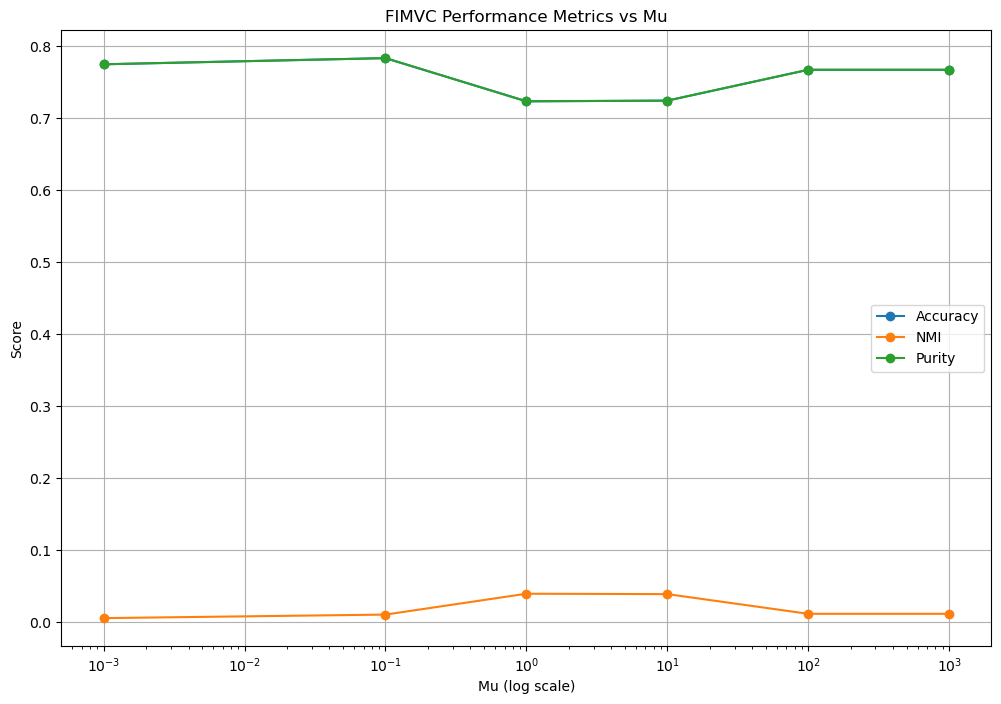

In [13]:
## Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(results_df['mu'], results_df['accuracy'], marker='o', label='Accuracy')
plt.plot(results_df['mu'], results_df['nmi'], marker='o', label='NMI')
plt.plot(results_df['mu'], results_df['purity'], marker='o', label='Purity')
plt.xscale('log')
plt.xlabel('Mu (log scale)')
plt.ylabel('Score')
plt.title('FIMVC Performance Metrics vs Mu')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
from helper_functions.embed_utils import Create_Transition_Mat, Create_Asym_Tran_Kernel

# Hyperparameter tuning on scale parameter
scale_grid = [0.1, 0.3, 0.5, 1, 2, 3, 5, 7, 10, 15, 20, 30]

print(f"\n{'='*80}")
print("HYPERPARAMETER TUNING: Scale Parameter Grid Search")
print(f"{'='*80}")
print(f"Scale values to test: {scale_grid}")
print(f"Methods: {sim_params['ad_methods']}")
print(f"{'='*80}\n")

# Store all results
all_results = []

for scale in tqdm(scale_grid, desc="Scale values"):
    print(f"\n{'='*60}")
    print(f"Testing Scale = {scale}")
    print(f"{'='*60}")
    K1, _ = Create_Transition_Mat(s1_full, scale=scale, mode=sim_params['sigma_mode'])
    K2, _ = Create_Transition_Mat(s2_full, scale=scale, mode=sim_params['sigma_mode'])
    A1, _, _ = Create_Asym_Tran_Kernel(s1_full, s1_ref, scale=scale, mode=sim_params['sigma_mode'])
    K2_ref, _ = Create_Transition_Mat(s2_ref, scale=scale, mode=sim_params['sigma_mode'])

    for method in sim_params['ad_methods']:
        print(f"\n  Method: {method.upper()}")
        try:
            # Generate embedding using embed_wrapper with current scale
            if method == 'ad':
                
                embedding = embed_wrapper(
                    s1_full=s1_full,
                    s2_full=s2_full,
                    method=method,
                    embed_dim=sim_params['embed_dim'],
                    t=sim_params['t'],
                    K1=K1,
                    K2=K2,
                    solver=sim_params['evd_solver']
                )
            else:
                # For adm_plus, create asymmetric and symmetric kernels
                embedding = embed_wrapper(
                    s1_ref=s1_ref,
                    s1_full=s1_full,
                    s2_ref=s2_ref,
                    method=method,
                    embed_dim=sim_params['embed_dim'],
                    t=sim_params['t'],
                    K1=A1,
                    K2=K2_ref,
                    solver=sim_params['evd_solver']
                )
            
            # Perform KMeans clustering
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            y_pred = kmeans.fit_predict(embedding)
            
            # Align clusters using Hungarian algorithm
            y_pred_aligned = align_clusters(y_true_aligned, y_pred)
            
            # Calculate metrics
            accuracy = np.mean(y_pred_aligned == y_true_aligned)
            nmi = normalized_mutual_info_score(y_true_aligned, y_pred)
            purity = calculate_purity(y_true_aligned, y_pred)
            ari = adjusted_rand_score(y_true_aligned, y_pred)
            
            print(f"    Accuracy: {accuracy:.4f}, NMI: {nmi:.4f}, Purity: {purity:.4f}, ARI: {ari:.4f}")
            
            all_results.append({
                'scale': scale,
                'method': method,
                'accuracy': accuracy,
                'nmi': nmi,
                'purity': purity,
                'ari': ari
            })
            
        except Exception as e:
            print(f"   Error at scale {scale}: {str(e)}")
            all_results.append({
                'scale': scale,
                'method': method,
                'accuracy': np.nan,
                'nmi': np.nan,
                'purity': np.nan,
                'ari': np.nan
            })

# Create results DataFrame
results_grid_df = pd.DataFrame(all_results)

# Print summary
print(f"\n{'='*80}")
print("GRID SEARCH RESULTS SUMMARY")
print(f"{'='*80}\n")
print(results_grid_df.to_string(index=False))

# Find best parameters for each method
print(f"\n{'='*80}")
print("BEST PARAMETERS BY METHOD")
print(f"{'='*80}\n")

for method in sim_params['ad_methods']:
    method_results = results_grid_df[results_grid_df['method'] == method]
    
    # Best by accuracy
    best_acc = method_results.loc[method_results['accuracy'].idxmax()]
    print(f"{method.upper()}:")
    print(f"  Best Accuracy: {best_acc['accuracy']:.4f} at scale={best_acc['scale']}")
    print(f"  Best NMI: {method_results.loc[method_results['nmi'].idxmax(), 'nmi']:.4f} at scale={method_results.loc[method_results['nmi'].idxmax(), 'scale']}")
    print(f"  Best Purity: {method_results.loc[method_results['purity'].idxmax(), 'purity']:.4f} at scale={method_results.loc[method_results['purity'].idxmax(), 'scale']}")
    print(f"  Best ARI: {method_results.loc[method_results['ari'].idxmax(), 'ari']:.4f} at scale={method_results.loc[method_results['ari'].idxmax(), 'scale']}")
    print()


HYPERPARAMETER TUNING: Scale Parameter Grid Search
Scale values to test: [0.1, 0.3, 0.5, 1, 2, 3, 5, 7, 10, 15, 20, 30]
Methods: ['ad', 'adm_plus', 'ncca', 'apmc']



Scale values:   0%|          | 0/12 [00:00<?, ?it/s]


Testing Scale = 0.1
 Kernel computation finished, in 0.9514546394348145 seconds
 Kernel computation finished, in 0.9514546394348145 seconds
 Kernel computation finished, in 1.2477867603302002 seconds
 Kernel computation finished, in 1.2477867603302002 seconds
 Kernel computation finished, in 0.838986873626709 seconds
 Kernel computation finished, in 0.2002558708190918 seconds

  Method: AD
 Kernel computation finished, in 0.838986873626709 seconds
 Kernel computation finished, in 0.2002558708190918 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7802, NMI: 0.0009, Purity: 0.7802, ARI: -0.0014

  Method: ADM_PLUS


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7802, NMI: 0.0009, Purity: 0.7802, ARI: -0.0014

  Method: NCCA


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7726, NMI: 0.0074, Purity: 0.7726, ARI: -0.0119

  Method: APMC


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
Scale values:   8%|▊         | 1/12 [00:09<01:46,  9.65s/it]

    Accuracy: 0.7802, NMI: 0.0009, Purity: 0.7802, ARI: -0.0014

Testing Scale = 0.3
 Kernel computation finished, in 0.9394443035125732 seconds
 Kernel computation finished, in 0.9394443035125732 seconds
 Kernel computation finished, in 1.3214843273162842 seconds
 Kernel computation finished, in 1.3214843273162842 seconds
 Kernel computation finished, in 0.8809628486633301 seconds
 Kernel computation finished, in 0.8809628486633301 seconds
 Kernel computation finished, in 0.20317840576171875 seconds

  Method: AD
 Kernel computation finished, in 0.20317840576171875 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.8126, NMI: 0.1491, Purity: 0.8126, ARI: 0.1564

  Method: ADM_PLUS


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7745, NMI: 0.0058, Purity: 0.7745, ARI: -0.0093

  Method: NCCA


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7745, NMI: 0.0058, Purity: 0.7745, ARI: -0.0093

  Method: APMC


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
Scale values:  17%|█▋        | 2/12 [00:16<01:19,  7.97s/it]

    Accuracy: 0.7745, NMI: 0.0058, Purity: 0.7745, ARI: -0.0093

Testing Scale = 0.5
 Kernel computation finished, in 0.9738614559173584 seconds
 Kernel computation finished, in 0.9738614559173584 seconds
 Kernel computation finished, in 1.2910058498382568 seconds
 Kernel computation finished, in 1.2910058498382568 seconds
 Kernel computation finished, in 0.9288961887359619 seconds
 Kernel computation finished, in 0.9288961887359619 seconds
 Kernel computation finished, in 0.2241520881652832 seconds

  Method: AD
 Kernel computation finished, in 0.2241520881652832 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

  Method: ADM_PLUS


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7678, NMI: 0.0111, Purity: 0.7678, ARI: -0.0181

  Method: NCCA


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7745, NMI: 0.0058, Purity: 0.7745, ARI: -0.0093

  Method: APMC


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
Scale values:  25%|██▌       | 3/12 [00:23<01:08,  7.64s/it]

    Accuracy: 0.7745, NMI: 0.0058, Purity: 0.7745, ARI: -0.0093

Testing Scale = 1
 Kernel computation finished, in 1.0911686420440674 seconds
 Kernel computation finished, in 1.0911686420440674 seconds
 Kernel computation finished, in 1.4555110931396484 seconds
 Kernel computation finished, in 1.4555110931396484 seconds
 Kernel computation finished, in 0.8591339588165283 seconds
 Kernel computation finished, in 0.20153546333312988 seconds

  Method: AD
 Kernel computation finished, in 0.8591339588165283 seconds
 Kernel computation finished, in 0.20153546333312988 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7726, NMI: 0.0074, Purity: 0.7726, ARI: -0.0119

  Method: ADM_PLUS


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

  Method: NCCA


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

  Method: APMC


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
Scale values:  33%|███▎      | 4/12 [00:31<01:00,  7.52s/it]

    Accuracy: 0.5718, NMI: 0.0045, Purity: 0.5718, ARI: 0.0132

Testing Scale = 2
 Kernel computation finished, in 1.2062804698944092 seconds
 Kernel computation finished, in 1.2062804698944092 seconds
 Kernel computation finished, in 1.5286495685577393 seconds
 Kernel computation finished, in 1.5286495685577393 seconds
 Kernel computation finished, in 0.8690872192382812 seconds
 Kernel computation finished, in 0.2026360034942627 seconds

  Method: AD
 Kernel computation finished, in 0.8690872192382812 seconds
 Kernel computation finished, in 0.2026360034942627 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7726, NMI: 0.0074, Purity: 0.7726, ARI: -0.0119

  Method: ADM_PLUS


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

  Method: NCCA


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

  Method: APMC


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
Scale values:  42%|████▏     | 5/12 [00:38<00:53,  7.58s/it]

    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

Testing Scale = 3
 Kernel computation finished, in 1.027144432067871 seconds
 Kernel computation finished, in 1.027144432067871 seconds
 Kernel computation finished, in 1.2937097549438477 seconds
 Kernel computation finished, in 1.2937097549438477 seconds
 Kernel computation finished, in 0.8437657356262207 seconds
 Kernel computation finished, in 0.8437657356262207 seconds
 Kernel computation finished, in 0.20354461669921875 seconds

  Method: AD
 Kernel computation finished, in 0.20354461669921875 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7726, NMI: 0.0074, Purity: 0.7726, ARI: -0.0119

  Method: ADM_PLUS


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

  Method: NCCA


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

  Method: APMC


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
Scale values:  50%|█████     | 6/12 [00:45<00:43,  7.32s/it]

    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

Testing Scale = 5
 Kernel computation finished, in 0.9568908214569092 seconds
 Kernel computation finished, in 0.9568908214569092 seconds
 Kernel computation finished, in 1.296067476272583 seconds
 Kernel computation finished, in 1.296067476272583 seconds
 Kernel computation finished, in 1.0053045749664307 seconds
 Kernel computation finished, in 1.0053045749664307 seconds
 Kernel computation finished, in 0.27977466583251953 seconds

  Method: AD
 Kernel computation finished, in 0.27977466583251953 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7983, NMI: 0.0678, Purity: 0.7983, ARI: 0.1150

  Method: ADM_PLUS


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

  Method: NCCA


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

  Method: APMC


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
Scale values:  58%|█████▊    | 7/12 [00:52<00:35,  7.19s/it]

    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

Testing Scale = 7
 Kernel computation finished, in 1.0749540328979492 seconds
 Kernel computation finished, in 1.0749540328979492 seconds
 Kernel computation finished, in 1.437678575515747 seconds
 Kernel computation finished, in 1.437678575515747 seconds
 Kernel computation finished, in 0.9275341033935547 seconds
 Kernel computation finished, in 0.19966864585876465 seconds

  Method: AD
 Kernel computation finished, in 0.9275341033935547 seconds
 Kernel computation finished, in 0.19966864585876465 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7983, NMI: 0.0678, Purity: 0.7983, ARI: 0.1150

  Method: ADM_PLUS


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

  Method: NCCA


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

  Method: APMC


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
Scale values:  67%|██████▋   | 8/12 [00:59<00:28,  7.16s/it]

    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

Testing Scale = 10
 Kernel computation finished, in 0.9977912902832031 seconds
 Kernel computation finished, in 0.9977912902832031 seconds
 Kernel computation finished, in 1.285085678100586 seconds
 Kernel computation finished, in 1.285085678100586 seconds
 Kernel computation finished, in 0.8202762603759766 seconds
 Kernel computation finished, in 0.8202762603759766 seconds
 Kernel computation finished, in 0.21456456184387207 seconds

  Method: AD
 Kernel computation finished, in 0.21456456184387207 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7983, NMI: 0.0678, Purity: 0.7983, ARI: 0.1150

  Method: ADM_PLUS


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

  Method: NCCA


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

  Method: APMC


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
Scale values:  75%|███████▌  | 9/12 [01:06<00:20,  6.98s/it]

    Accuracy: 0.5167, NMI: 0.0002, Purity: 0.5167, ARI: 0.0000

Testing Scale = 15
 Kernel computation finished, in 0.9949555397033691 seconds
 Kernel computation finished, in 0.9949555397033691 seconds
 Kernel computation finished, in 1.3246643543243408 seconds
 Kernel computation finished, in 1.3246643543243408 seconds
 Kernel computation finished, in 0.8202376365661621 seconds
 Kernel computation finished, in 0.8202376365661621 seconds
 Kernel computation finished, in 0.2071983814239502 seconds

  Method: AD
 Kernel computation finished, in 0.2071983814239502 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7983, NMI: 0.0678, Purity: 0.7983, ARI: 0.1150

  Method: ADM_PLUS


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

  Method: NCCA


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

  Method: APMC


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
Scale values:  83%|████████▎ | 10/12 [01:13<00:14,  7.04s/it]

    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

Testing Scale = 20
 Kernel computation finished, in 1.0469605922698975 seconds
 Kernel computation finished, in 1.0469605922698975 seconds
 Kernel computation finished, in 1.2415056228637695 seconds
 Kernel computation finished, in 1.2415056228637695 seconds
 Kernel computation finished, in 0.8211400508880615 seconds
 Kernel computation finished, in 0.19665312767028809 seconds

  Method: AD
 Kernel computation finished, in 0.8211400508880615 seconds
 Kernel computation finished, in 0.19665312767028809 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.8002, NMI: 0.0745, Purity: 0.8002, ARI: 0.1239

  Method: ADM_PLUS


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

  Method: NCCA


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

  Method: APMC


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
Scale values:  92%|█████████▏| 11/12 [01:20<00:06,  6.96s/it]

    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

Testing Scale = 30
 Kernel computation finished, in 1.1101605892181396 seconds
 Kernel computation finished, in 1.1101605892181396 seconds
 Kernel computation finished, in 1.2741799354553223 seconds
 Kernel computation finished, in 1.2741799354553223 seconds
 Kernel computation finished, in 0.86509108543396 seconds
 Kernel computation finished, in 0.86509108543396 seconds
 Kernel computation finished, in 0.21301817893981934 seconds

  Method: AD
 Kernel computation finished, in 0.21301817893981934 seconds

  Method: AD


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.8002, NMI: 0.0745, Purity: 0.8002, ARI: 0.1239

  Method: ADM_PLUS


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

  Method: NCCA


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

  Method: APMC


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
Scale values: 100%|██████████| 12/12 [01:27<00:00,  7.29s/it]

    Accuracy: 0.7735, NMI: 0.0066, Purity: 0.7735, ARI: -0.0106

GRID SEARCH RESULTS SUMMARY

 scale   method  accuracy      nmi   purity       ari
   0.1       ad  0.780209 0.000882 0.780209 -0.001367
   0.1 adm_plus  0.780209 0.000882 0.780209 -0.001367
   0.1     ncca  0.772598 0.007396 0.772598 -0.011881
   0.1     apmc  0.780209 0.000882 0.780209 -0.001367
   0.3       ad  0.812559 0.149106 0.812559  0.156409
   0.3 adm_plus  0.774500 0.005840 0.774500 -0.009323
   0.3     ncca  0.774500 0.005840 0.774500 -0.009323
   0.3     apmc  0.774500 0.005840 0.774500 -0.009323
   0.5       ad  0.773549 0.006623 0.773549 -0.010608
   0.5 adm_plus  0.767840 0.011120 0.767840 -0.018080
   0.5     ncca  0.774500 0.005840 0.774500 -0.009323
   0.5     apmc  0.774500 0.005840 0.774500 -0.009323
   1.0       ad  0.772598 0.007396 0.772598 -0.011881
   1.0 adm_plus  0.773549 0.006623 0.773549 -0.010608
   1.0     ncca  0.773549 0.006623 0.773549 -0.010608
   1.0     apmc  0.571836 0.004534 0.57183

In [15]:
for method in sim_params['ad_methods']:
    method_results = results_grid_df[results_grid_df['method'] == method]
    
    # Best by accuracy
    best_acc = method_results.loc[method_results['accuracy'].idxmax()]
    print(f"{method.upper()}:")
    print(f"  Best Accuracy: {best_acc['accuracy']:.4f} at scale={best_acc['scale']}")
    print(f"  Best NMI: {method_results.loc[method_results['nmi'].idxmax(), 'nmi']:.4f} at scale={method_results.loc[method_results['nmi'].idxmax(), 'scale']}")
    print(f"  Best Purity: {method_results.loc[method_results['purity'].idxmax(), 'purity']:.4f} at scale={method_results.loc[method_results['purity'].idxmax(), 'scale']}")
    print(f"  Best ARI: {method_results.loc[method_results['ari'].idxmax(), 'ari']:.4f} at scale={method_results.loc[method_results['ari'].idxmax(), 'scale']}")
    print()

AD:
  Best Accuracy: 0.8126 at scale=0.3
  Best NMI: 0.1491 at scale=0.3
  Best Purity: 0.8126 at scale=0.3
  Best ARI: 0.1564 at scale=0.3

ADM_PLUS:
  Best Accuracy: 0.7802 at scale=0.1
  Best NMI: 0.0111 at scale=0.5
  Best Purity: 0.7802 at scale=0.1
  Best ARI: -0.0014 at scale=0.1

NCCA:
  Best Accuracy: 0.7745 at scale=0.3
  Best NMI: 0.0074 at scale=0.1
  Best Purity: 0.7745 at scale=0.3
  Best ARI: -0.0093 at scale=0.3

APMC:
  Best Accuracy: 0.7802 at scale=0.1
  Best NMI: 0.0066 at scale=2.0
  Best Purity: 0.7802 at scale=0.1
  Best ARI: 0.0132 at scale=1.0



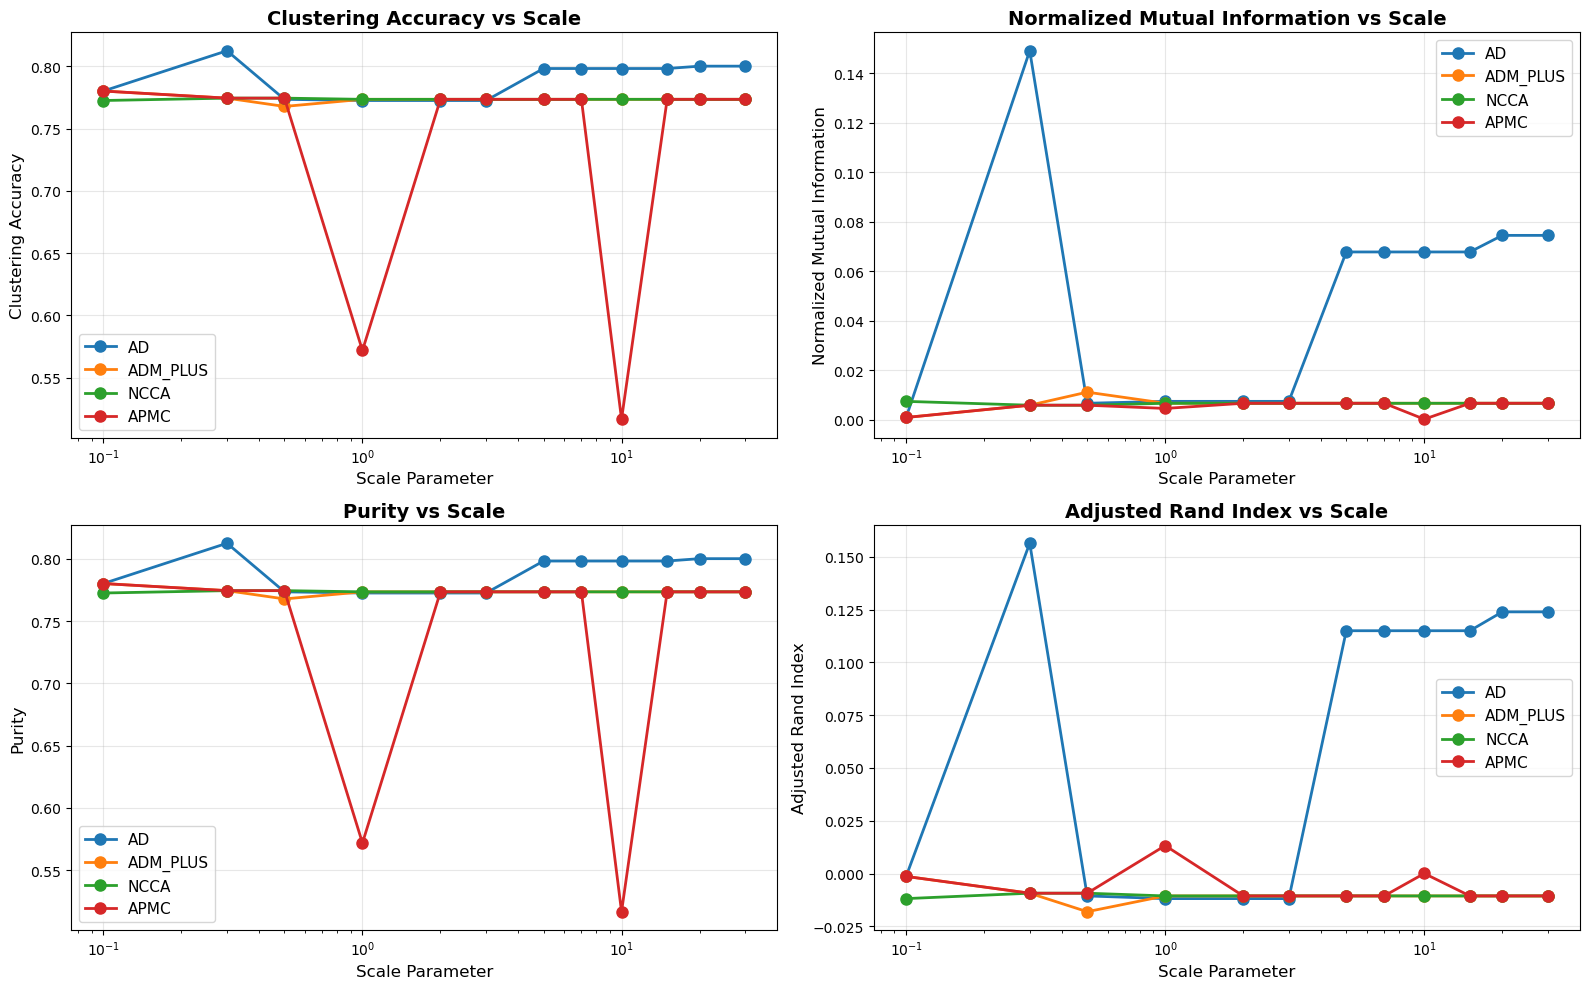


Dataset: WebKB
Missing ratio: 0.5
Embedding dimension: 30
Diffusion time: 0


In [16]:
# Visualize grid search results
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

metrics = ['accuracy', 'nmi', 'purity', 'ari']
titles = ['Clustering Accuracy', 'Normalized Mutual Information', 'Purity', 'Adjusted Rand Index']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx]
    
    for method in sim_params['ad_methods']:
        method_data = results_grid_df[results_grid_df['method'] == method]
        ax.plot(method_data['scale'], method_data[metric], marker='o', label=method.upper(), linewidth=2, markersize=8)
    
    ax.set_xlabel('Scale Parameter', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.set_title(f'{title} vs Scale', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')

plt.tight_layout()
plt.show()

print(f"\nDataset: {sim_params['dataset']}")
print(f"Missing ratio: {sim_params['missing_ratio']}")
print(f"Embedding dimension: {sim_params['embed_dim']}")
print(f"Diffusion time: {sim_params['t']}")